This Notebook contains the code used to obtain the Figures (and Tables) associated with the paper

## Import librairies

In [145]:
%reload_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

## Librairies for plotting
import seaborn as sns
import pandas as pd
from matplotlib.legend import Legend
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D

## import functions from external .py scripts
from git_CME_scores import *
from git_AnDA_stat_functions import *
from git_idealized_AMOC_model import *

## other
import warnings
warnings.filterwarnings("ignore")
from numpy import savetxt
import os
import re
import itertools
from scipy.integrate import odeint  

Populating the interactive namespace from numpy and matplotlib


## Import data files

In [ ]:
# function to automatically identify a unique file or folder at a specific path based on a regexp pattern
def identify_file_folder_byregexp(path, regexp):
    res=''
    for file in os.listdir(path):
        if re.search(regexp, file):
            res=file
        else:
            res=res
    return path+'/'+res

In [146]:
# #path = '/home/...' 

# ## 11~MODEL-CATALOGS (for the three variables)
# catalogs_omega = loadtxt(path+"/normstd_catalogs_omega.csv", delimiter=';')
# catalogs_sbt = loadtxt(path+"/normstd_catalogs_sbt.csv", delimiter=';')
# catalogs_sns = loadtxt(path+"/normstd_catalogs_sns.csv", delimiter=';')

# ## 11~NOISY-OBSERVATIONS SET AND RELATED TRUE STATES (only for the variable of interest 'omega')
# obs = loadtxt(path+"/normstd_obs.csv", delimiter=';')
# xts = loadtxt(path+"/normstd_xts.csv", delimiter=';')

# ## 11~AnDA OUTPUTS FORECASTS STATES (mean and covariances) OF THE 11~LEAVE-ONE-OUT EXPERIMENTS (only for the variable of interest 'omega')
# list_anda_outputs_for_regexp = ['XFSomega_anda', 'PFSomega_anda']
# for i_mod_as_obs in range(catalogs_omega.shape[0]):
#     path_to_experiment = identify_file_folder_byregexp(path, "_param_"+str(i_mod_as_obs)+"as_obs")   
#     list_var_names = ['XFSomega_anda_obs'+str(i_mod_as_obs), 'PFSomega_anda_obs'+str(i_mod_as_obs)]
#     for i in range(len(list_anda_outputs_for_regexp)):
#         path_to_csv = identify_file_folder_byregexp(path_to_experiment, list_anda_outputs_for_regexp[i])
#         globals()[list_var_names[i]] = loadtxt(path_to_csv, delimiter=';')      

## Number of perturbed versions (here: 11)
nb_param=catalogs_omega.shape[0]


# EXPERIMENTAL SETUP

## Figure 2: attractors of the 11~perturbed versions of the 3-variable AMOC model (with normalized variables)

In [70]:
############## 11~PERTURBED MODEL PARAMETERS ###############

### all possible combinations of parameters 
fact_param=0.5 # the factor referring to the degree of similarity between the parameterizations (closer from 1 is fact_param, more similar they are)

### REFERENCES VALUES FOR THE PARAMETERS OF THE IDEALIZED AMOC MODEL (from Sévellec and Fedorov, 2014)
## perturbed parameters
ref_lambdaa = 0.01
ref_epsilon = 0.35
ref_Omega0 = -0.025
ref_K = 0.0001

# fixed parameters
ref_F0 = 1
ref_beta = 0.0007
ref_S0 = 35
ref_h = 1000 

# all the possible combinations of *fact_param, /fact_param, fact_param
list_lambdaa = [ref_lambdaa, ref_lambdaa*fact_param] 
list_epsilon = [ref_epsilon, ref_epsilon*fact_param]
list_Omega0 = [ref_Omega0, ref_Omega0*fact_param, ref_Omega0/fact_param]
list_K = [ref_K, ref_K*fact_param, ref_K/fact_param]
list_parameters = [list_lambdaa, list_epsilon, list_Omega0, list_K]
param_combin = list(itertools.product(*list_parameters))
param_combin = param_combin[0:len(param_combin)-9] #-9 to delete identical parameterizations

## subset of 11 parameterizations selected for the study
list_param_exp = [0,3,5,7,9,11,13,15,16,17,19]


### GENERATE SIMULATIONS ### 
nb_states = 30000 # simulation size
all_simu = [] # before scaling
all_simu_norm = [] #after scaling

for i in list_param_exp :
    params = param_combin[i]
    
    # definition of the model's parameters
    class model_phy:
        model = 'ideal_AMOC'
        class parameters:
            ## perturbed parameters
            lambdaa = params[0]
            epsilon = params[1]
            Omega0 = params[2]
            K = params[3]
            
            ## fixed parameters 
            F0 = ref_F0
            beta = ref_beta
            S0 = ref_S0
            h = ref_h 
    
    # We keep the last state of a preliminary data generation (size: 100) to initialize the simulations
    x0 = np.array([0,0,0]);
    pre_simu_i = odeint(AnDA_ideal_AMOC, x0,np.arange(0,100+0.000001, 1),
                   args=(model_phy.parameters.lambdaa, model_phy.parameters.epsilon, model_phy.parameters.beta, model_phy.parameters.Omega0,
                         model_phy.parameters.K,model_phy.parameters.F0, model_phy.parameters.S0,model_phy.parameters.h))  
    x00 = pre_simu_i[pre_simu_i.shape[0]-1,:]
    simu_i = odeint(AnDA_ideal_AMOC, x00,np.arange(0, nb_states+0.000001, 1),
                   args=(model_phy.parameters.lambdaa, model_phy.parameters.epsilon, model_phy.parameters.beta, model_phy.parameters.Omega0,
                         model_phy.parameters.K,model_phy.parameters.F0, model_phy.parameters.S0,model_phy.parameters.h))
    all_simu.append(simu_i)
    
    # normalize each variable by scaling 
    simu_i_norm = simu_i/ np.std(simu_i, axis=0)
    all_simu_norm.append(simu_i_norm)  
    

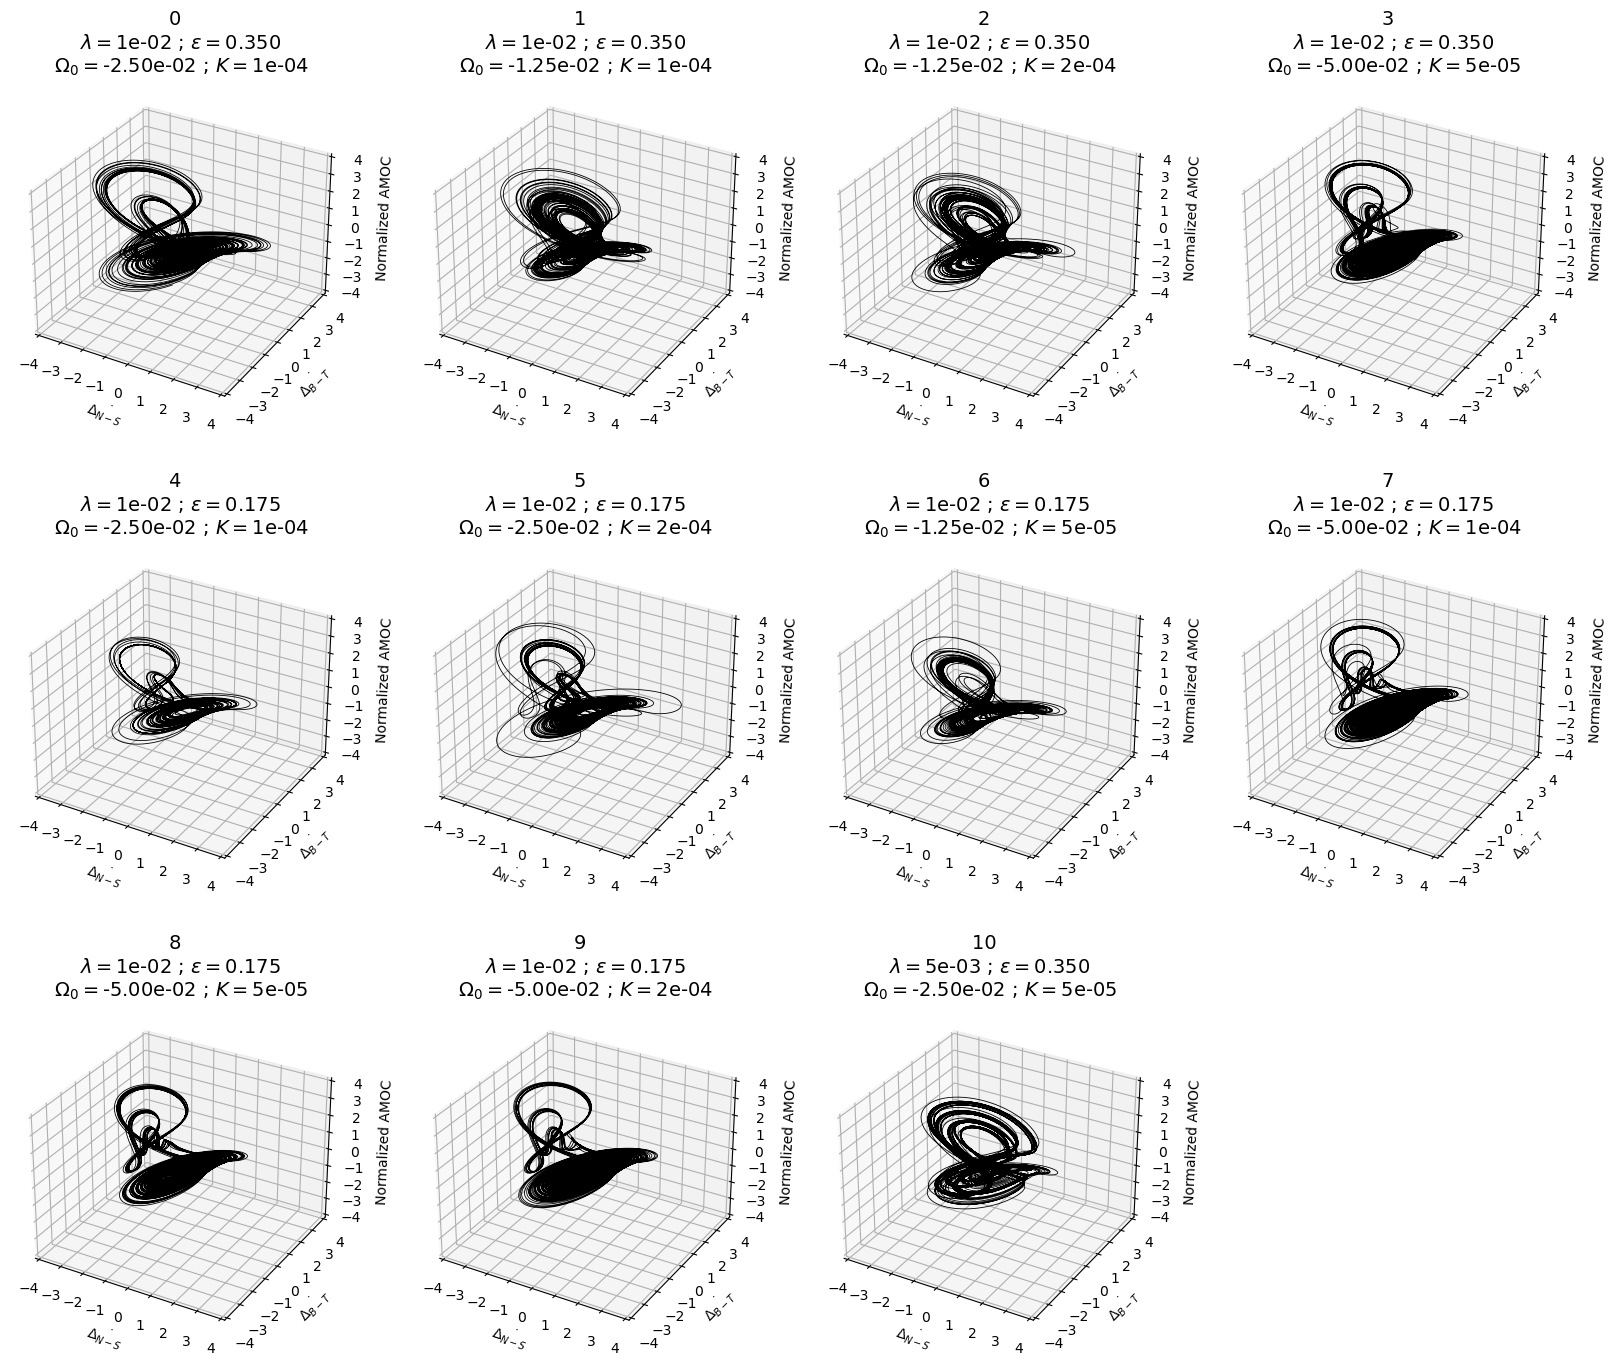

In [71]:
### PLOT FIGURE 2

plt.figure(figsize=(20,17))
                      
for i_param in range(nb_param):
    model = all_simu_norm[i_param]
    omega = model[:,0] 
    sbt = model[:,1]
    sns = model[:,2]
    
    num_panel = i_param+1
    ax = fig.add_subplot(3, 4, num_panel, projection='3d')
    ax.plot(sbt, sns, omega, linewidth=0.6, color="black")
    ax.set_title(label='%.0f \n $\lambda=$%.0e ; $\epsilon=$%.3f \n $\Omega_0=$%.2e ; $K=$%.0e' %(i_param,
                                                                                                  param_combin[list_param_exp[i_param]][0],
                                                                                                  param_combin[list_param_exp[i_param]][1],
                                                                                                  param_combin[list_param_exp[i_param]][2],
                                                                                                  param_combin[list_param_exp[i_param]][3]), fontsize=14)                                                                                     
    ax.set_xlabel('$\dot{\Delta_{N-S}}$');ax.set_ylabel('$\dot{\Delta_{B-T}}$');ax.set_zlabel("Normalized AMOC") 
    ax.set_xlim(-4,4);ax.set_ylim(-4,4);ax.set_zlim(-4,4)
    
plt.show()


## Figure 3: distributions of normalized AMOC for the 11~perturbed versions of the 3-variable AMOC model

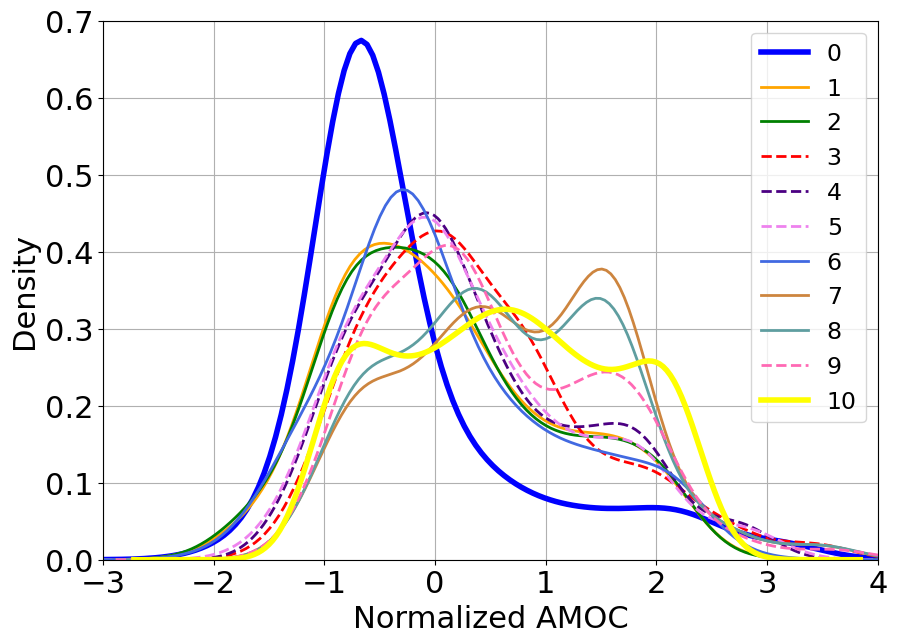

In [78]:
## Parameters for the figure: line characteristics and number of bins for the PDFs
list_colors = ["blue","orange","green","red","indigo", "violet","royalblue","peru","cadetblue","hotpink", "yellow"]
list_linestyle = ['-','-','-','--','--','--','-','-','-','--','-']
list_linewidth = [4,2,2,2,2,2,2,2,2,2,4]
nb_bins=1000

plt.figure(figsize=(10,7))

for i_param in range(nb_param):
    model = catalogs_omega
    counts_mod, bins_mod = np.histogram(model[i_param,:], bins=nb_bins, range=(np.amin(model[i_param,:]), np.amax(model[i_param,:])))
    pdf = sns.distplot(bins_mod[:-1], hist = False, kde = True, bins=bins_mod, vertical=False,
                       kde_kws = {'weights':counts_mod,'linewidth':list_linewidth[i_param] ,'linestyle':list_linestyle[i_param], 'color':list_colors[i_param]}, label=i_param)
            
plt.xlabel("Normalized AMOC", fontsize=22)  
plt.ylabel("Density", fontsize=22) 
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim((-3,4))
plt.ylim((0,0.7))
plt.grid()
plt.legend(loc='upper right', fontsize=17)

plt.show()


# PERFECT MODEL EXPERIMENT
Results for individual experiment.
The object 'i_mod_as_obs' allows to select the experiment to show (indices between 0 and 10). By default 'i_mod_as_obs=8'

In [172]:
## SELECT THE RESULTS OF THE MODEL 8 EXPERIMENT
i_mod_as_obs = 8
XFSomega_anda = globals()[f"XFSomega_anda_obs{i_mod_as_obs}"] #forecasts mean state for the 11~models assimilated with observations generated with model 8
PFSomega_anda = globals()[f"PFSomega_anda_obs{i_mod_as_obs}"] #covariances for the 11~models assimilated with observations generated with model 8
obs_anda = obs[i_mod_as_obs,:]
err_obs_vect = np.repeat([0.5], obs_anda.shape[0])
xts_anda = xts[i_mod_as_obs,:]
time_obs = np.arange(0, 8000, 20) #8000 yrs at each dt=20 yrs 


## Figure 4: Illustrative forecasts series for three models and related CME series for model 8 experiment

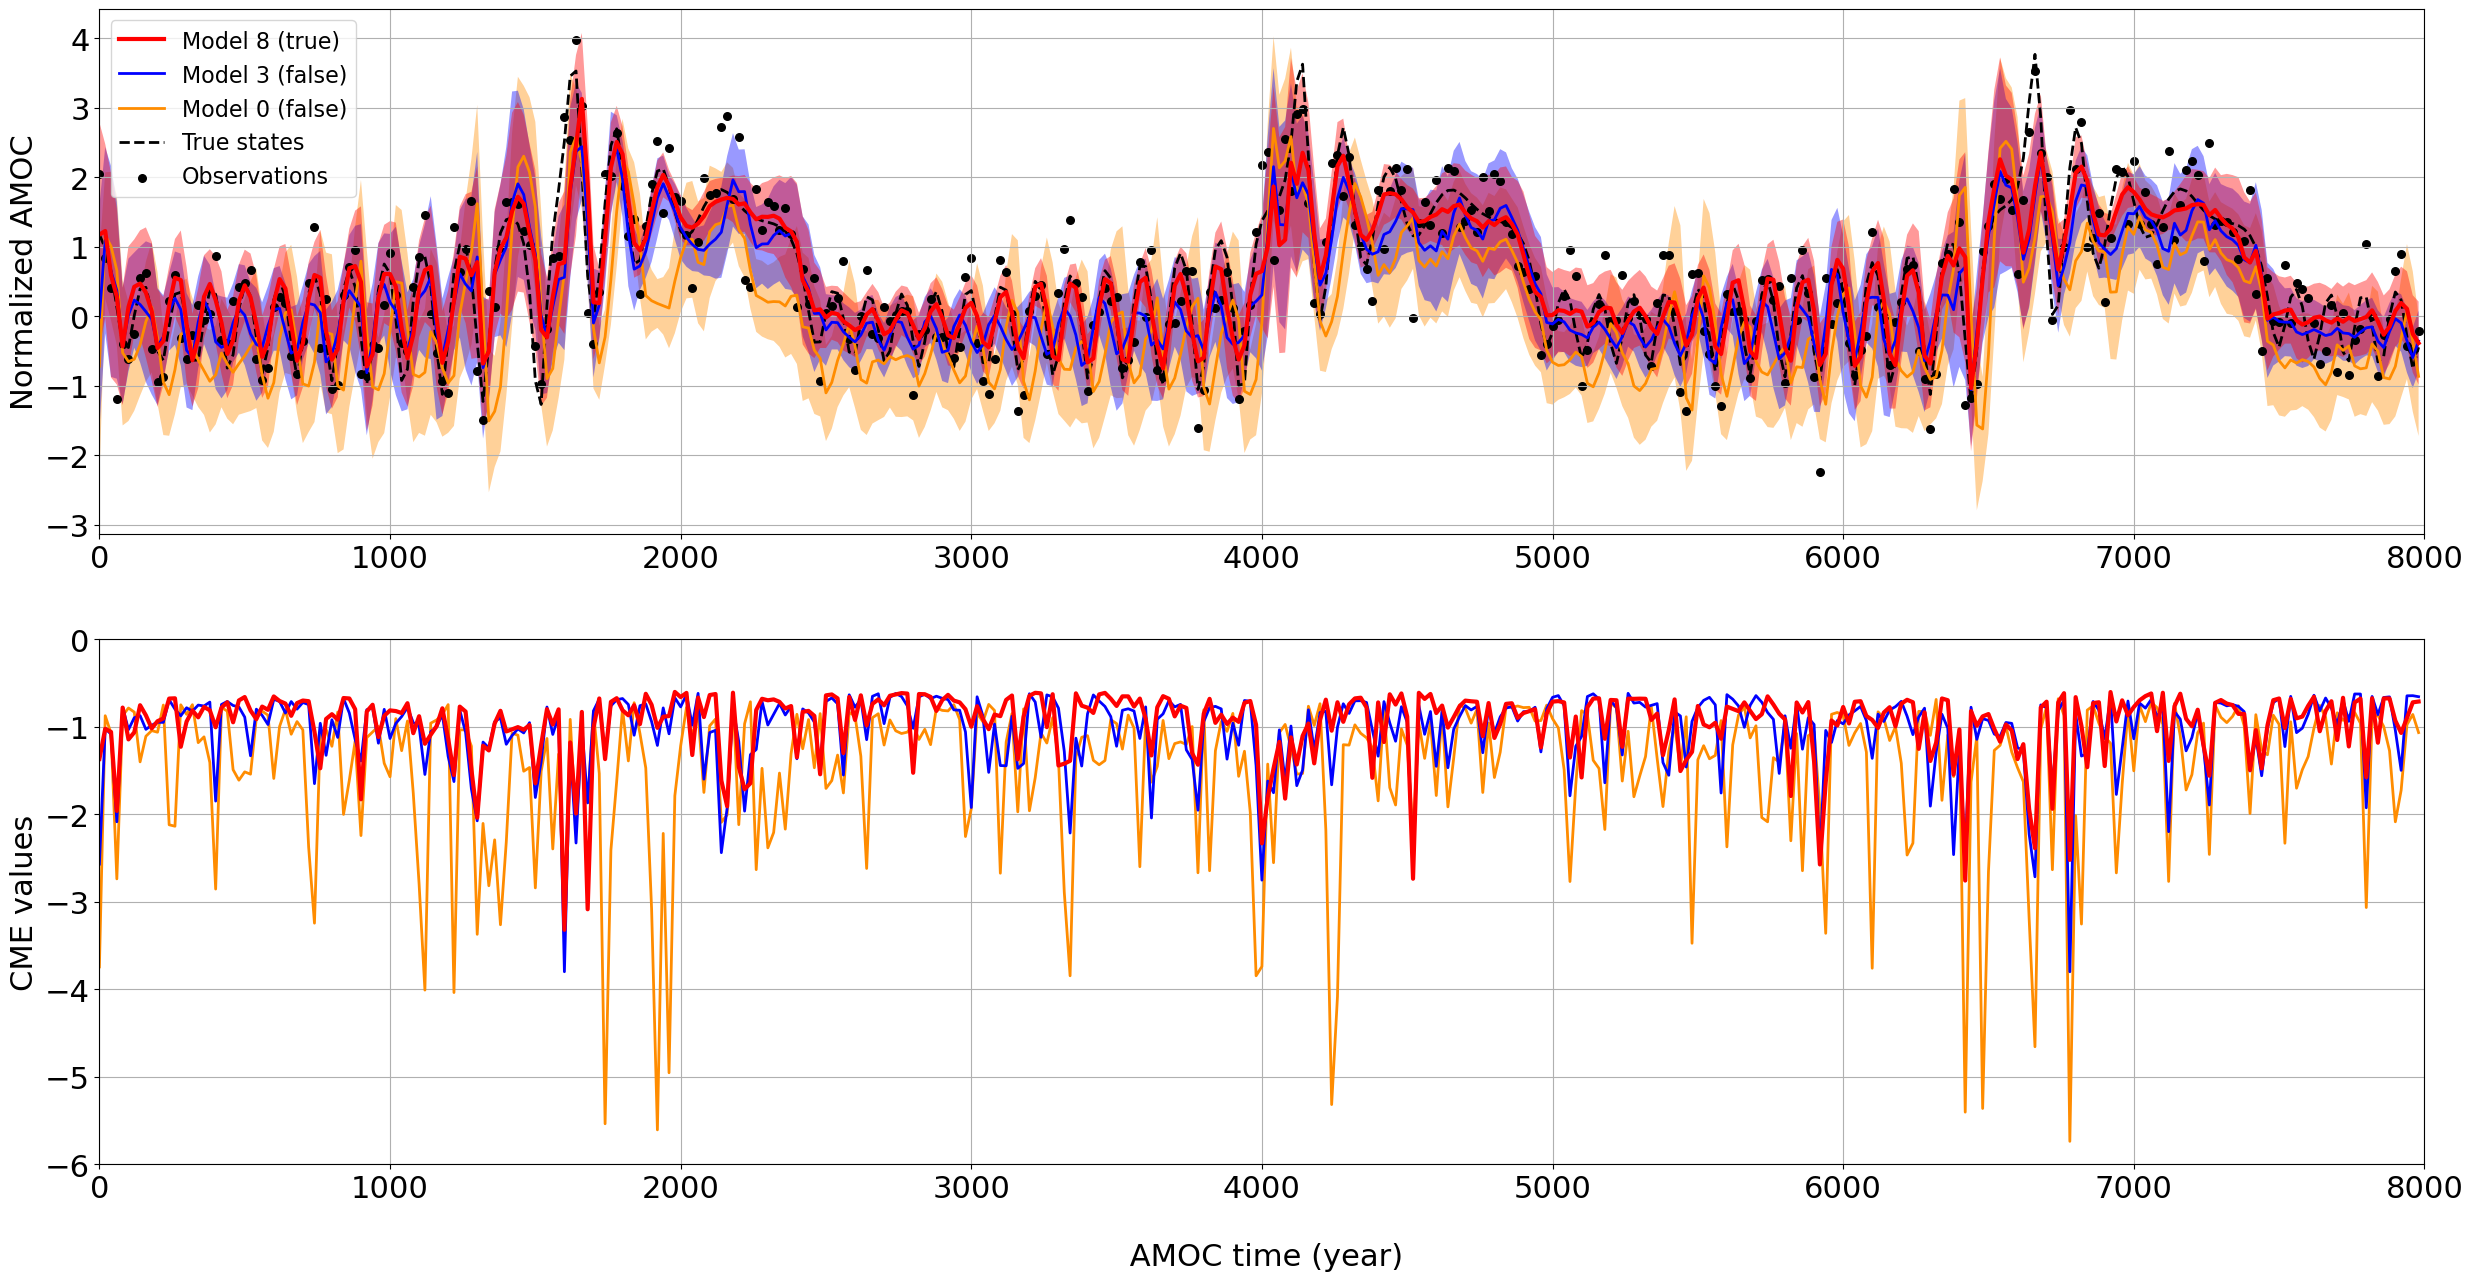

In [148]:
plt.figure(figsize=(30,15))

## TOP PANEL: FORECASTS SERIES
plt.subplot(2,1,1)

## true states
plt.plot(time_obs, xts_anda,'--k', linewidth=2, label="True states")

## Examples with three illustrative models
## model 0
id_0 = 0
plt.plot(time_obs, XFSomega_anda[id_0,:], color="darkorange", label="Model 0 (false)", linewidth=2)
plt.fill_between(time_obs, XFSomega_anda[id_0,:]-1.654*np.sqrt(PFSomega_anda[id_0,:]),
                 XFSomega_anda[id_0,:]+1.654*np.sqrt(PFSomega_anda[id_0,:]), facecolor="darkorange", alpha=0.4)

## model 3
id_3 = 3
plt.plot(time_obs, XFSomega_anda[id_3,:],color="blue",label="Model 3 (false)",linewidth=2)
plt.fill_between(time_obs, XFSomega_anda[id_3,:]-1.654*np.sqrt(PFSomega_anda[id_3,:]),
                 XFSomega_anda[id_3,:]+1.654*np.sqrt(PFSomega_anda[id_3,:]), facecolor="blue", alpha=0.4)

## model 8 (the true one)
id_8 = 8
plt.plot(time_obs, XFSomega_anda[id_8,:],color="red",label="Model 8 (true)",linewidth=3)
plt.fill_between(time_obs, XFSomega_anda[id_8,:]-1.654*np.sqrt(PFSomega_anda[id_8,:]),
                 XFSomega_anda[id_8,:]+1.654*np.sqrt(PFSomega_anda[id_8,:]), facecolor="red", alpha=0.4)

## observations
plt.scatter(time_obs, obs_anda,c="black", s=30, label="Observations")


## change label order in legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 2, 1, 0, 4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', fontsize=16)
plt.ylabel("Normalized AMOC", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,8000)
plt.grid()


## BOTTOM PANEL: CME SERIES 
plt.subplot(2,1,2)

# Compite the CME series related to omega variable for the 11~models
CMEs_anda = np.zeros((nb_param, obs_anda.shape[0]))
for i_param in range(nb_param):
    CMEs_anda[i_param,:] = online_CME_metric_1D(obs_anda, err_obs_vect, XFSomega_anda[i_param,:], PFSomega_anda[i_param,:], dim_target=1)

plt.plot(time_obs, CMEs_anda[0,:],color="darkorange",linewidth=2)
plt.plot(time_obs, CMEs_anda[3,:],color="blue",linewidth=2)
plt.plot(time_obs, CMEs_anda[8,:],color="red",linewidth=3)

plt.xlabel("\n AMOC time (year)", fontsize=22)
plt.ylabel("CME values", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,8000)
plt.ylim(-6,0)
plt.grid()

plt.show()


## Figure 5: CME distributions for the 11~models 

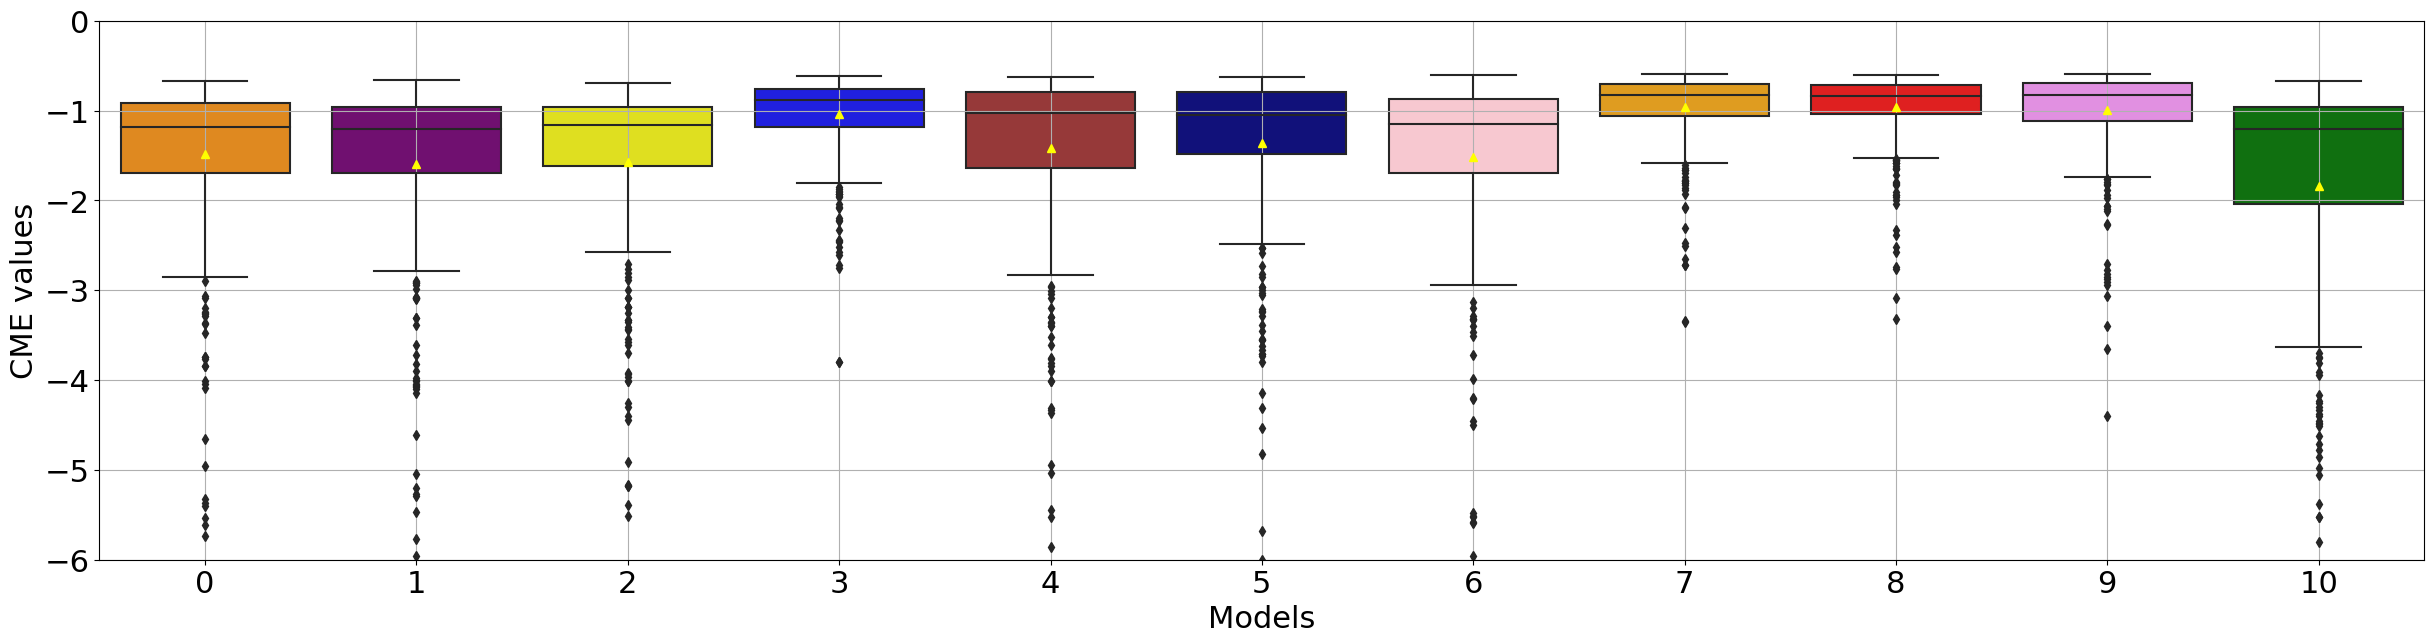

In [149]:
plt.figure(figsize=(30,7))

sns.set_palette(boxplot_colors)
sns.boxplot(data=CMEs_anda.tolist(), showmeans=True, width=0.8)#, color=list_colors[0:nb_param])
plt.ylim(-6,0)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Models", fontsize=22)
plt.ylabel("CME values", fontsize=22)
plt.grid()

plt.show()


## Table 1: model weights for each strategy in the perfect case using model 8 for pseudo-observations

In [150]:
include_obs_arg=True # perfect experiments include the true model within the framework 

vect_weights_methods = {}

## Model democracy
w_democracy = vect_weights_model_democracy(nb_param, include_obs=include_obs_arg)
vect_weights_methods["Model democracy"] = w_democracy

## Climatologies comparison
w_climato = vect_weights_distributions_comparison(catalogs_omega, obs_anda, nb_bins=20, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
vect_weights_methods["Climatologies"] = w_climato

## Best single model
w_bestsingle = best_model_weight(catalogs_omega, obs_anda, nb_bins=20, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
vect_weights_methods["Best single model"] = w_bestsingle

## CME ClimWIP
sig_perf=0.3 
sig_indep=0.4
w_cmeclimwip = vect_weights_cme_climwip(XFSomega_anda, PFSomega_anda, obs_anda, err_obs_vect, sig_perf, sig_indep, ind_obs=i_mod_as_obs, dim_target=1, include_obs=include_obs_arg, indep_score=True)
vect_weights_methods["CME ClimWIP"] = w_cmeclimwip

## CME best punctual
w_cmebestpunctual, mat_01 = best_local_model_CME_01(obs_anda, err_obs_vect, XFSomega_anda, PFSomega_anda, ind_obs=i_mod_as_obs, dim_target=1, include_obs=include_obs_arg)
vect_weights_methods["CME best punctual"] = w_cmebestpunctual

## CME best persistent
w_cmebestpersistent = best_local_consecutive_cumul_CME(obs_anda, err_obs_vect, XFSomega_anda, PFSomega_anda, ind_obs=i_mod_as_obs, fact_reward=1, dim_target=1, include_obs=include_obs_arg)
vect_weights_methods["CME best persistent"] = w_cmebestpersistent

## Create and display the table with the weights
tab_weights_mod8 = pd.DataFrame.from_dict(vect_weights_methods, orient='index').round(4)*100
tab_weights_mod8   


,0,1,2,3,4,5,6,7,8,9,10
Model democracy,9.09,9.09,9.09,9.09,9.09,9.09,9.09,9.09,9.09,9.09,9.09
Climatologies,6.23,8.95,9.01,9.82,9.59,9.56,8.51,9.46,9.59,9.96,9.32
Best single model,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00
CME ClimWIP,0.13,0.04,0.05,16.15,0.27,0.48,0.09,30.39,31.22,21.17,0.00
CME best punctual,4.00,2.25,2.00,10.00,8.25,6.50,4.75,12.25,16.75,24.00,9.25
CME best persistent,3.28,1.93,1.73,8.48,7.32,5.97,5.01,12.52,17.53,28.13,8.09


# IMPERFECT MODEL EXPERIMENT
Results for individual experiment.
The object 'i_mod_as_obs' allows to select the experiment to show (indices between 0 and 10). By default 'i_mod_as_obs = 8'

## Generate new simulations of omega for the 11~model versions
Useful to perform the distribution reconstructions

In [143]:
nb_states = 2000000
dt_states = 20 
omega_simus_norm = np.zeros((nb_param, np.int(nb_states/dt_states+1))) 

i_array_out = -1
for i_param in list_param_exp :
    i_array_out = i_array_out + 1
    params = param_combin[i_param]
    
    # definition of the model's parameters
    class model_phy:
        model = 'ideal_AMOC'
        class parameters:
            ## perturbed parameters
            lambdaa = params[0]
            epsilon = params[1]
            Omega0 = params[2]
            K = params[3]
            
            ## fixed parameters 
            F0 = ref_F0
            beta = ref_beta
            S0 = ref_S0
            h = ref_h 
    
    # We keep the last state of a preliminary data generation (size: 100) to initialize the simulations
    x0 = np.array([0,0,0]);
    new_simu_i = odeint(AnDA_ideal_AMOC, x0,np.arange(0,nb_states+0.000001, dt_states),
                   args=(model_phy.parameters.lambdaa, model_phy.parameters.epsilon, model_phy.parameters.beta, model_phy.parameters.Omega0,
                         model_phy.parameters.K,model_phy.parameters.F0, model_phy.parameters.S0,model_phy.parameters.h))  
    omega_simus_norm[i_array_out,:] = new_simu_i[:,0]/ np.std(new_simu_i[:,0])
    

## Figure 6: Reconstruction of a missing distribution (here with model 8) + associated Table of model weights

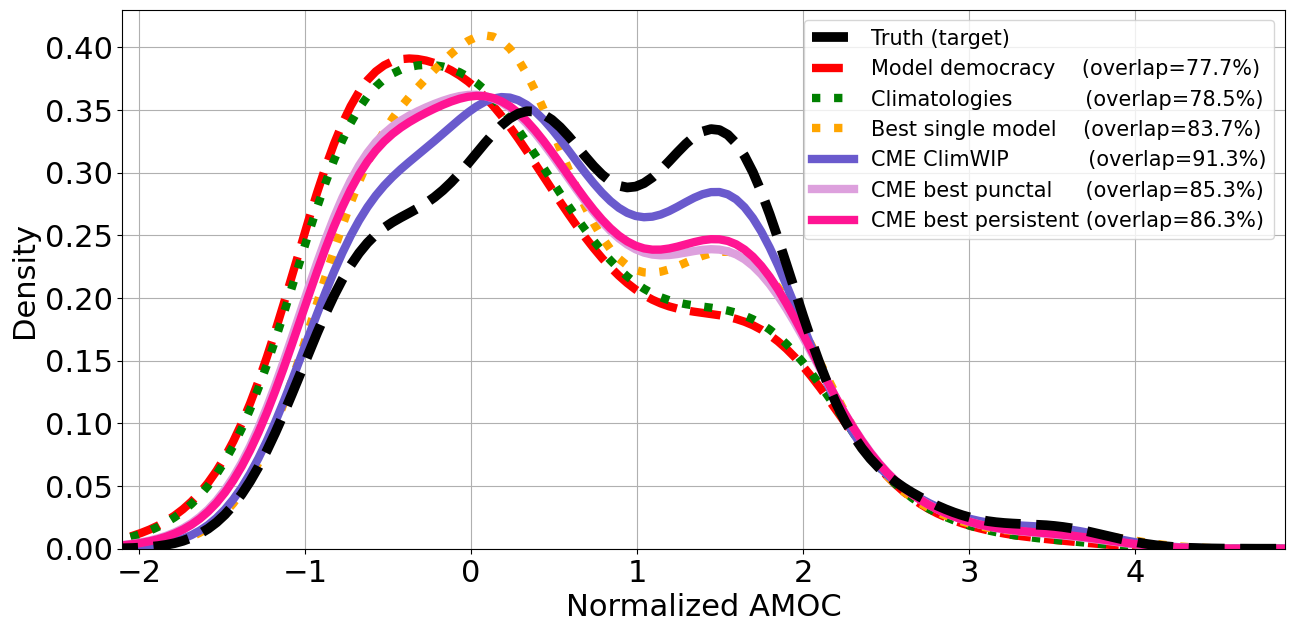

,0,1,2,3,4,5,6,7,8,9,10
Model democracy,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,NaN,10.00,10.00
Climatologies,6.89,9.90,9.97,10.86,10.61,10.57,9.41,10.46,NaN,11.02,10.31
Best single model,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,100.00,0.00
CME ClimWIP,0.13,0.04,0.06,18.09,0.27,0.47,0.10,49.08,NaN,31.75,0.00
CME best punctual,4.00,2.25,2.25,10.50,8.25,6.50,4.75,26.75,NaN,25.50,9.25
CME best persistent,3.18,1.87,1.87,9.16,7.10,5.79,4.86,29.72,NaN,28.60,7.85


In [184]:
#### FIGURE PARAMETERS: LABELS AND COLORS
colors_methods= {"Model democracy    ":"red",
                 "Climatologies           ":"green", 
                 "Best single model    ":"orange",
                 "CME ClimWIP            ":"slateblue",
                 "CME best punctal     ":"plum",
                 "CME best persistent ":"deeppink"
                } 
labels_methods = list(colors_methods.keys())

## Number of bins for the distributions
nb_bins=1000

## imperfect model case here
include_obs_arg=False

## dictionnary to store the model weights for each score
vect_weights_methods_i = {}

########## WEIGHTS CALCULATION FOR EACH SCORE + PLOT RECONSTRUCTED PDF ##########
plt.figure(figsize=(15,7))

## Distribution of the true model (to compare with for overlap scores calculation)
counts_obs, bins_obs = np.histogram(omega_simus_norm[i_mod_as_obs,:], bins=nb_bins, range=(np.amin(omega_simus_norm), np.amax(omega_simus_norm)))
bins_fig = bins_obs
  
    
## Model democracy
w_democracy_i = vect_weights_model_democracy(nb_param, include_obs=include_obs_arg)
vect_weights_methods_i["Model democracy"] = w_democracy_i

# weighted histogram
bins, counts_pdf_mod_democracy, final_w_pdf_democracy = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_democracy_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)

# overlap score (phi)
phi_democracy = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_democracy, nb_decim=1)
   
# plot distribution
pdf_democracy = sns.distplot(bins_fig[:-1], hist = False, kde = True, bins=bins_fig,
                             kde_kws = {'weights':final_w_pdf_democracy,'linewidth': 6, 'linestyle':'dashed'},
                             color=colors_methods[labels_methods[0]],
                             label=labels_methods[0]+"(overlap="+str(phi_democracy[1])+"%)")


## Climatologies comparison
w_climato_i = vect_weights_distributions_comparison(catalogs_omega, obs_anda, nb_bins=20, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
vect_weights_methods_i["Climatologies"] = w_climato_i

# weighted histogram
bins, counts_pdf_mod_climato, final_w_pdf_climato = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_climato_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)

# overlap score (phi)
phi_climato = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_climato, nb_decim=1)
   
# plot distribution
pdf_climato = sns.distplot(bins_fig[:-1], hist = False, kde = True, bins=bins_fig,
                             kde_kws = {'weights':final_w_pdf_climato,'linewidth': 6, 'linestyle':'dotted'},
                             color=colors_methods[labels_methods[1]],
                             label=labels_methods[1]+"(overlap="+str(phi_climato[1])+"%)")


## Best single model
w_bestsingle_i = best_model_weight(catalogs_omega, obs_anda, nb_bins=20, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
vect_weights_methods_i["Best single model"] = w_bestsingle_i

# weighted histogram
bins, counts_pdf_mod_bestsingle, final_w_pdf_bestsingle = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_bestsingle_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)

# overlap score (phi)
phi_bestsingle = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_bestsingle, nb_decim=1)
   
# plot distribution
pdf_bestsingle = sns.distplot(bins_fig[:-1], hist = False, kde = True, bins=bins_fig,
                             kde_kws = {'weights':final_w_pdf_bestsingle,'linewidth': 6, 'linestyle':'dotted'},
                             color=colors_methods[labels_methods[2]],
                             label=labels_methods[2]+"(overlap="+str(phi_bestsingle[1])+"%)")

## CME ClimWIP
sig_perf_i=0.3
sig_indep_i=1
w_cmeclimwip_i = vect_weights_cme_climwip(XFSomega_anda, PFSomega_anda, obs_anda, err_obs_vect, sig_perf_i, sig_indep_i, ind_obs=i_mod_as_obs, dim_target=1, include_obs=include_obs_arg, indep_score=True)
vect_weights_methods_i["CME ClimWIP"] = w_cmeclimwip_i

# weighted histogram
bins, counts_pdf_mod_cmeclimwip, final_w_pdf_cmeclimwip = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_cmeclimwip_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)

# overlap score (phi)
phi_cmeclimwip = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_cmeclimwip, nb_decim=1)
   
# plot distribution
pdf_cmeclimwip = sns.distplot(bins_fig[:-1], hist = False, kde = True, bins=bins_fig,
                             kde_kws = {'weights':final_w_pdf_cmeclimwip,'linewidth': 6},
                             color=colors_methods[labels_methods[3]],
                             label=labels_methods[3]+"(overlap="+str(phi_cmeclimwip[1])+"%)")


## CME best punctual
w_cmebestpunctual_i, mat_01 = best_local_model_CME_01(obs_anda, err_obs_vect, XFSomega_anda, PFSomega_anda, ind_obs=i_mod_as_obs, dim_target=1, include_obs=include_obs_arg)
vect_weights_methods_i["CME best punctual"] = w_cmebestpunctual_i

# weighted histogram
bins, counts_pdf_mod_cmebestpunctual, final_w_pdf_cmebestpunctual = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_cmebestpunctual_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)

# overlap score (phi)
phi_cmebestpunctual = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_cmebestpunctual, nb_decim=1)
   
# plot distribution
pdf_cmebestpunctual = sns.distplot(bins_fig[:-1], hist = False, kde = True, bins=bins_fig,
                             kde_kws = {'weights':final_w_pdf_cmebestpunctual,'linewidth': 6},
                             color=colors_methods[labels_methods[4]],
                             label=labels_methods[4]+"(overlap="+str(phi_cmebestpunctual[1])+"%)")

## CME best persistent
w_cmebestpersistent_i = best_local_consecutive_cumul_CME(obs_anda, err_obs_vect, XFSomega_anda, PFSomega_anda, ind_obs=i_mod_as_obs, fact_reward=1, dim_target=1, include_obs=include_obs_arg)
vect_weights_methods_i["CME best persistent"] = w_cmebestpersistent_i

# weighted histogram
bins, counts_pdf_mod_cmebestpersistent, final_w_pdf_cmebestpersistent = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_cmebestpersistent_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)

# overlap score (phi)
phi_cmebestpersistent = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_cmebestpersistent, nb_decim=1)
   
# plot distribution
pdf_cmebestpersistent = sns.distplot(bins_fig[:-1], hist = False, kde = True, bins=bins_fig,
                             kde_kws = {'weights':final_w_pdf_cmebestpersistent,'linewidth': 6},
                             color=colors_methods[labels_methods[5]],
                             label=labels_methods[5]+"(overlap="+str(phi_cmebestpersistent[1])+"%)")
    

## PLOT THE TRUE DISTRIBUTION
pdf_truth = sns.distplot(bins_fig[:-1], hist = False, kde = True, bins=bins_fig,
                         kde_kws = {'weights':counts_obs,'linewidth': 7,'linestyle':'dashed', 'color':"black"},
                         hist_kws={'weights':counts_obs, 'color':"grey", 'density':True},
                         label="Truth (target)")
    
## change label order in legend for better visualize the curves
handles, labels = plt.gca().get_legend_handles_labels()
order = [6,0,1,2,3,4,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right', fontsize=15)
plt.xlabel("Normalized AMOC", fontsize=22) 
plt.ylabel("Density", fontsize=22) 
plt.xticks(fontsize=22) 
plt.yticks(fontsize=22) 
plt.xlim((-2.1,4.9))
plt.grid()
    
plt.show()

## Create and display the table with the weights
tab_weights_mod8_i = pd.DataFrame.from_dict(vect_weights_methods_i, orient='index').round(4)*100
tab_weights_mod8_i.insert(i_mod_as_obs, str(i_mod_as_obs), [NaN] * 6, True)
tab_weights_mod8_i.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
tab_weights_mod8_i 


## Figure 7: Reconstruction of a missing distribution for the eleven experiments (Leave-One-Out experiments)

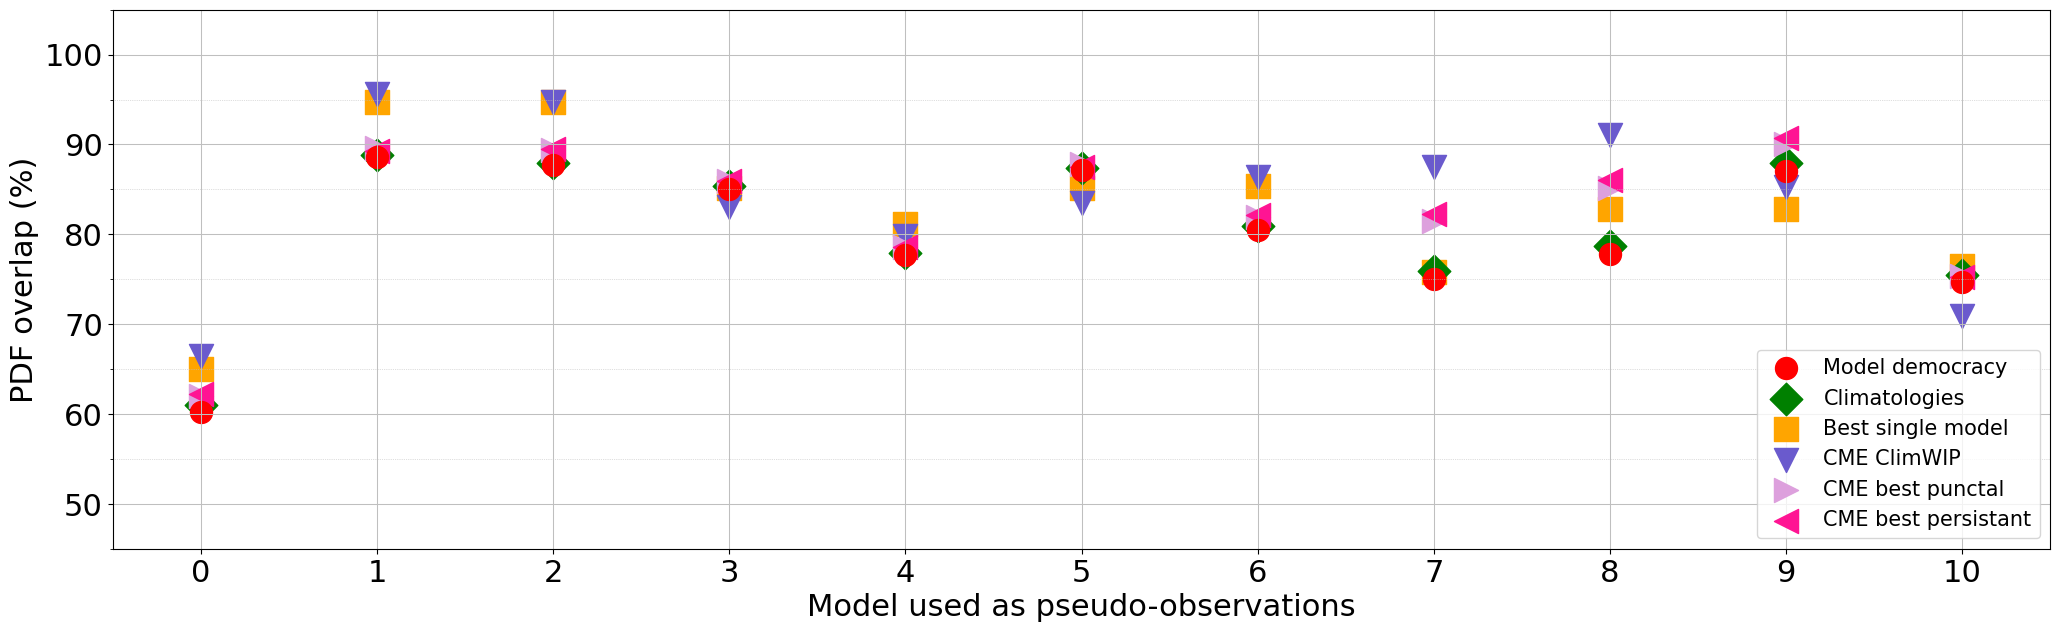

In [169]:
## Number of bins for the distributions
nb_bins=1000

## imperfect model case here
include_obs_arg=False

## For CME-ClimWIP score
sig_perf_i=0.5
sig_indep_i=0.7

## array to store the overlap scores for the six scores in the 11~experiments
mat_overlap_score_allexp = np.zeros((6, nb_param))

## CALCULATE THE OVERLAP SCORE FOR THE SIX SCORES IN THE 11~EXPERIMENTS
for i_mod_as_obs in range(nb_param):
    
    XFSomega_anda = globals()[f"XFSomega_anda_obs{i_mod_as_obs}"]
    PFSomega_anda = globals()[f"PFSomega_anda_obs{i_mod_as_obs}"]
    XFSomega_anda = XFSomega_anda[0:nb_param,:]
    PFSomega_anda = PFSomega_anda[0:nb_param,:]
    obs_anda = obs[i_mod_as_obs,:]

    ## Distribution of the true model (to compare with for overlap scores calculation)
    counts_obs, bins_obs = np.histogram(omega_simus_norm[i_mod_as_obs,:], bins=nb_bins, range=(np.amin(omega_simus_norm), np.amax(omega_simus_norm)))
      
    ## Model democracy
    w_democracy_i = vect_weights_model_democracy(nb_param, include_obs=include_obs_arg)
    bins, counts_pdf_mod_democracy, final_w_pdf_democracy = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_democracy_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    phi_democracy = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_democracy, nb_decim=1)
    mat_overlap_score_allexp[0, i_mod_as_obs] = phi_democracy[1]

    ## Climatologies comparison
    w_climato_i = vect_weights_distributions_comparison(catalogs_omega, obs_anda, nb_bins=20, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    bins, counts_pdf_mod_climato, final_w_pdf_climato = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_climato_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    phi_climato = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_climato, nb_decim=1)
    mat_overlap_score_allexp[1, i_mod_as_obs] = phi_climato[1]
   
    ## Best single model
    w_bestsingle_i = best_model_weight(catalogs_omega, obs_anda, nb_bins=20, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    bins, counts_pdf_mod_bestsingle, final_w_pdf_bestsingle = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_bestsingle_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    phi_bestsingle = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_bestsingle, nb_decim=1)
    mat_overlap_score_allexp[2, i_mod_as_obs] = phi_bestsingle[1]
   
    ## CME ClimWIP
    w_cmeclimwip_i = vect_weights_cme_climwip(XFSomega_anda, PFSomega_anda, obs_anda, err_obs_vect, sig_perf_i, sig_indep_i, ind_obs=i_mod_as_obs, dim_target=1, include_obs=include_obs_arg, indep_score=True)
    bins, counts_pdf_mod_cmeclimwip, final_w_pdf_cmeclimwip = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_cmeclimwip_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    phi_cmeclimwip = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_cmeclimwip, nb_decim=1)
    mat_overlap_score_allexp[3, i_mod_as_obs] = phi_cmeclimwip[1]

    ## CME best punctual
    w_cmebestpunctual_i, mat_01 = best_local_model_CME_01(obs_anda, err_obs_vect, XFSomega_anda, PFSomega_anda, ind_obs=i_mod_as_obs, dim_target=1, include_obs=include_obs_arg)
    bins, counts_pdf_mod_cmebestpunctual, final_w_pdf_cmebestpunctual = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_cmebestpunctual_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    phi_cmebestpunctual = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_cmebestpunctual, nb_decim=1)
    mat_overlap_score_allexp[4, i_mod_as_obs] = phi_cmebestpunctual[1]

    ## CME best persistent
    w_cmebestpersistent_i = best_local_consecutive_cumul_CME(obs_anda, err_obs_vect, XFSomega_anda, PFSomega_anda, ind_obs=i_mod_as_obs, fact_reward=1, dim_target=1, include_obs=include_obs_arg)
    bins, counts_pdf_mod_cmebestpersistent, final_w_pdf_cmebestpersistent = weighted_PDF_by_bins(omega_simus_norm, nb_bins, w_cmebestpersistent_i, ind_obs=i_mod_as_obs, include_obs=include_obs_arg)
    phi_cmebestpersistent = perf_metric_coverage_btw_two_pdfs(counts_obs, final_w_pdf_cmebestpersistent, nb_decim=1)
    mat_overlap_score_allexp[5, i_mod_as_obs] = phi_cmebestpersistent[1] 

## PLOT FIGURE 7
overlap_imperfect = mat_overlap_score_allexp

f = plt.figure(figsize=(25,7))
ax = f.add_subplot(111)
ax.set_ylim((45,105))
ax.tick_params(axis='both', which='major', labelsize=22)
ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))

ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='y', linewidth=0.5, linestyle=':', color='0.75')

x_ticks = np.arange(nb_param)
ax.scatter(x_ticks, overlap_imperfect[2,:], marker="s", s=300, color="orange", label="Best single model")
ax.scatter(x_ticks, overlap_imperfect[1,:], marker="D", s=275, color="green", label="Climatologies")
ax.scatter(x_ticks, overlap_imperfect[3,:], marker="v", s=300, color="slateblue", label="CME ClimWIP")
ax.scatter(x_ticks, overlap_imperfect[4,:], marker=">", s=300, color="plum", label="CME best punctal")
ax.scatter(x_ticks, overlap_imperfect[5,:], marker="<", s=300, color="deeppink", label="CME best persistant")
ax.scatter(x_ticks, overlap_imperfect[0,:], marker="o", s=250, color="red", label="Model democracy")

ax.set_xlabel("Model used as pseudo-observations", fontsize=22)  
ax.set_ylabel("PDF overlap (%)", fontsize=22)
handles, labels = plt.gca().get_legend_handles_labels()
order = [5, 1, 0, 2, 3, 4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', fontsize=15)
plt.show()    
